# Estimating Material Thickness

Goal is to estimate the thickness of each material in the material stack using breakpoint detection on the torque signal.

The code requires the script material_split.py from the sandbox folder

In [2]:
import material_split as msplit
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
import dataparser as dp
import ruptures as rpt

The material_split file contains several function and classes for applying changepoint detection algorithms from [rupture](https://centre-borelli.github.io/ruptures-docs/), [jenkspy](https://github.com/mthh/jenkspy) and the [BreakpointFit](modelling.py) class in the modelling.py file. They're just wrapper functions to load in a Setitec file, process it and produce a matplotlib figure to show.

The purpose of the functions is to investigate how the algorithms distribute the breakpoints, where they fit, sensitivity to metaparameters etc.

## Pruned Exact Linear Time (PELT)

PELT wants to split a signal into a finite number of sections. It prunes them to a manageable set according to a linear cost function. The paper for the method can be found [here](https://www.tandfonline.com/doi/pdf/10.1080/01621459.2012.737745?casa_token=KOGcqO6XqnkAAAAA:5Rqt3txpp2YKWYu9CyIyUvtRNtT6MOY6u6YIVdymZdR8--bwMMAodDfy3MGeqHUyPwCQZkwDbbtCvw). The special bit of PELT is removing breakpoints that can never be a minima of the cost function.The ruptures package supports several cost models; L1, L2 and RBF.

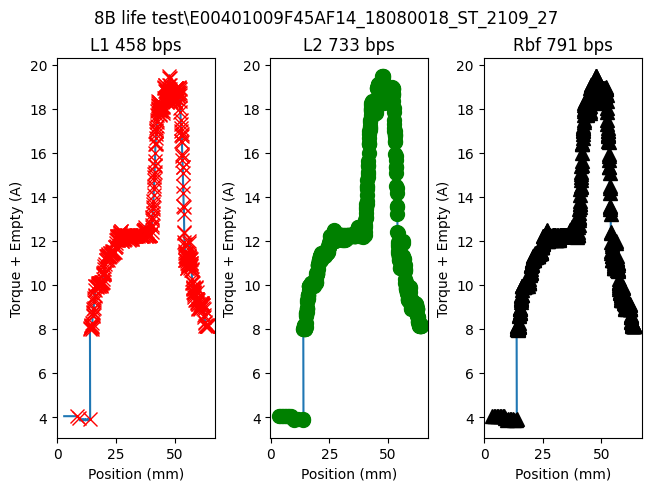

In [11]:
# as an example, the function tryPelt applies the PELT algorithm and the supported cost function
# and plots the signal with the found breakpoints
# the axis title states the cost function and how many breakpoints were found

f = msplit.tryPelt(glob("8B life test/*.xls")[0])
plt.show()

For some of the algorithms, the number of breakpoints can be specified. For the ones that can't like PELT, you control the number of breakpoints using the penalty parameter. A higher penalty parameter reduces the number of breakpoints, affects how they're spread and how long the algorithm takes

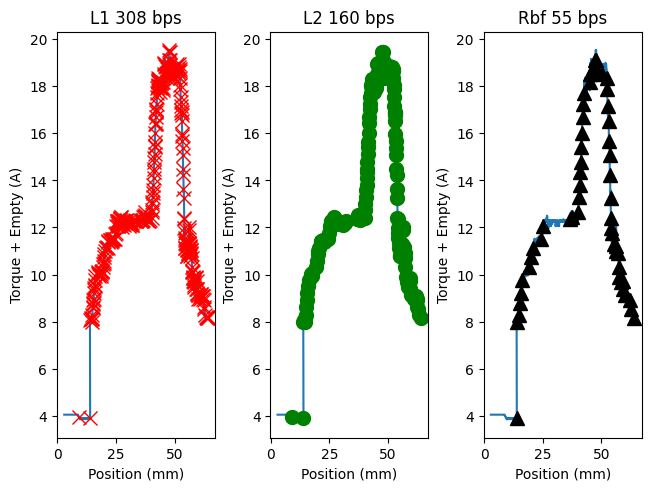

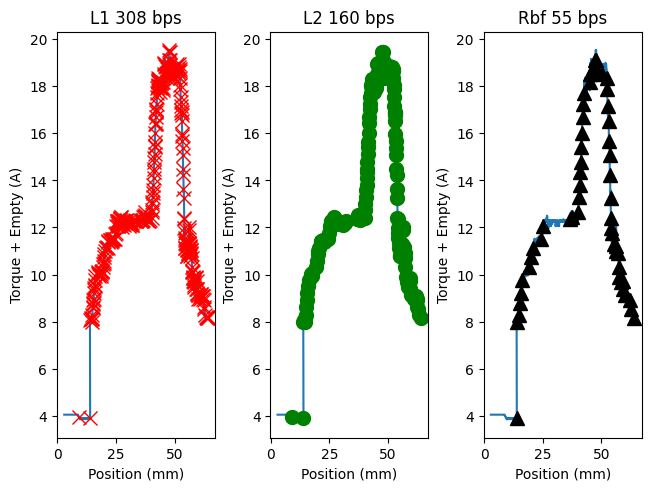

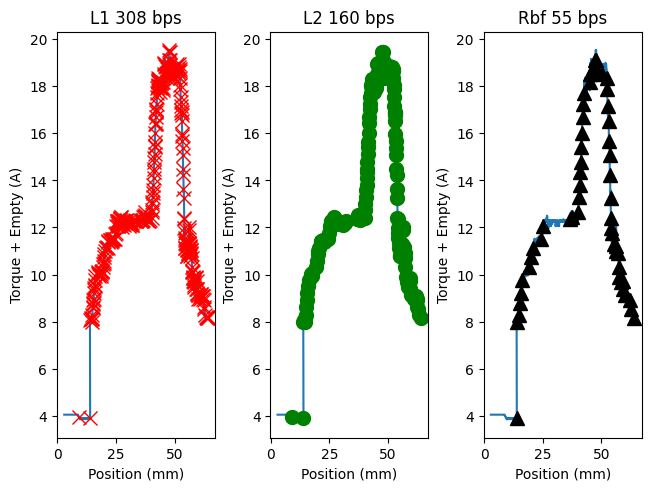

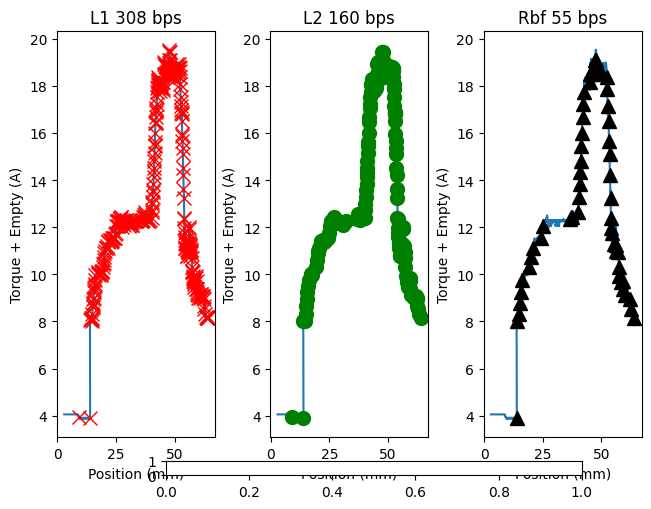

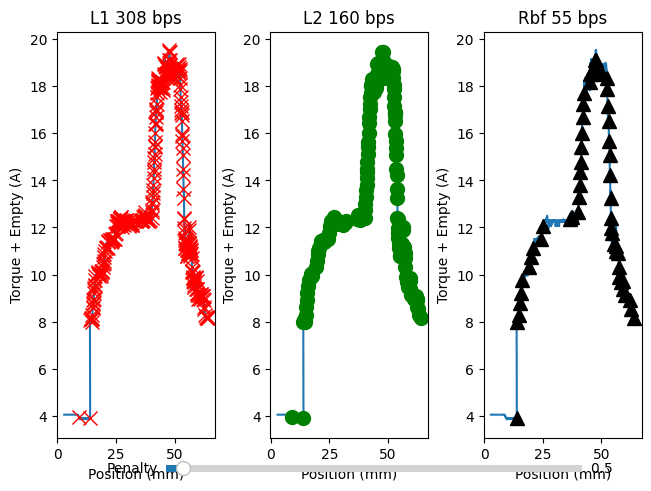

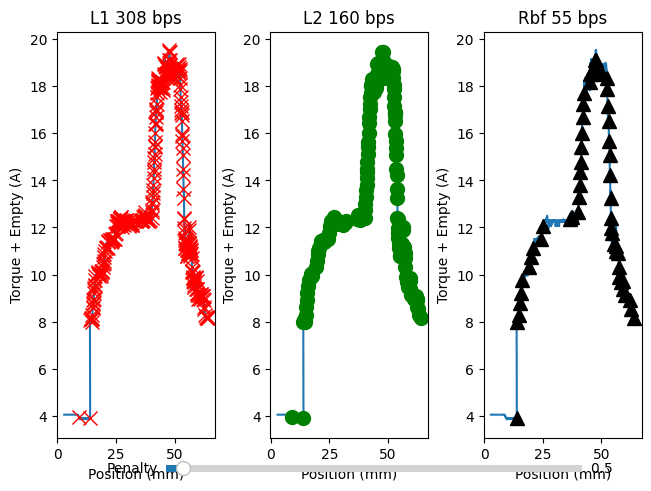

In [27]:
%matplotlib inline
from matplotlib.widgets import Slider
path = glob("8B life test/*.xls")[0]
models = ["l1","l2","rbf"]
markers = ['rx','go','k^']
min_sz = 3
jump = 5

fig,ax = plt.subplots(ncols=len(models),constrained_layout=True)
data = dp.loadSetitecXls(path,version="auto_data")
signal = data['I Torque (A)'].values + data['I Torque Empty (A)'].values
pos = np.abs(data['Position (mm)'].values)

bps = []
for aa,model,mk in zip(ax.flatten(),models,markers):
    aa.plot(pos,signal,label='Original')
    algo = rpt.Pelt(model=model, min_size=min_sz, jump=jump).fit(signal)
    my_bkps = np.asarray(algo.predict(pen=0.1))
    bps.append(aa.plot(pos[my_bkps-1],signal[my_bkps-1],mk,label=model,markersize=10)[0])
    aa.set(xlabel="Position (mm)",ylabel="Torque + Empty (A)",title=f"{model.capitalize()} {len(my_bkps)} bps")

axpen = fig.add_axes([0.25, 0.02, 0.65, 0.03])
pen_slider = Slider(
    ax=axpen,
    label='Penalty',
    valmin=0.1,
    valmax=10,
)

def update(val):
    p = pen_slider.val
    print(f"processing with penalty {p}")
    while bps:
        bps.pop().remove()
    for aa,model,mk in zip(ax.flatten(),models,markers):
        algo = rpt.Pelt(model=model, min_size=min_sz, jump=jump).fit(signal)
        my_bkps = np.asarray(algo.predict(pen=p))
        bps.append(aa.plot(pos[my_bkps-1],signal[my_bkps-1],mk,label=model,markersize=10)[0])
        aa.set_title(f"{model.capitalize()} {len(my_bkps)} bps")
pen_slider.on_changed(update)
plt.show()

## Gaussian Mixture Model

Another approach to estimating the materials is Gaussian Mixture Models (GMM). This attempts to separate the signal into a limited number of Gaussian signals. For our use case, the gaussian distribution should fit well as the material response follows the rise and fall characteristics and the two materials are distinct in the x-axis.

We'll be using [sklearn's](https://scikit-learn.org/stable/modules/mixture.html) implementation as it's simple to use. It has two forms of GMM; regular and variational.

### Regular GMM

In [3]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

#### Two Components

In [9]:
path = glob("8B life test/*.xls")[0]
data = dp.loadSetitecXls(path,version="auto_data")  
# using the raw signals as features
# not using thrust empty as not all files have it
X = np.column_stack((data['I Torque (A)'].values,
                     data['I Torque Empty (A)'].values,
                     np.abs(data['Position (mm)'].values),
                     data['I Thrust (A)'].values))
# inititalize GMM for 2 components (materials)
gm = GaussianMixture(n_components=2, random_state=0, max_iter=1000,covariance_type='spherical',reg_covar=1e-6).fit(X)
print(f"used {gm.n_iter_} its")
print(f"weights {gm.weights_}")
print(f"converged {gm.converged_}")
# print the means and covariances
# means : (components, features)
print(gm.means_,gm.means_.shape)
#(n_components,)                        if 'spherical',
#(n_features, n_features)               if 'tied',
#(n_components, n_features)             if 'diag',
#(n_components, n_features, n_features) if 'full'
print(gm.covariances_,gm.covariances_.shape)
# predict by feeding in the same features
Y = gm.predict(X)
print(Y,Y.shape)

used 3 its
weights [0.5149067 0.4850933]
converged True
[[6.10505775e+00 8.00800037e+00 5.08275219e+01 5.20794917e-02]
 [3.20897306e+00 7.82031267e+00 2.49324719e+01 3.75344274e-02]] (2, 4)
[18.79037972 15.49675649] (2,)
[1 1 1 ... 0 0 0] (3953,)


[[6.10505775e+00 8.00800037e+00 5.08275219e+01 5.20794917e-02]
 [3.20897306e+00 7.82031267e+00 2.49324719e+01 3.75344274e-02]] (2, 4)
[18.79037972 15.49675649] (2,)
50.82752186650979
24.93247191438782


[Text(0.5, 0, 'Position (mm)'),
 Text(0, 0.5, 'Torque (A)'),
 Text(0.5, 1.0, '8B life test\\E00401009F45AF14_18080018_ST_2109_27.xls')]

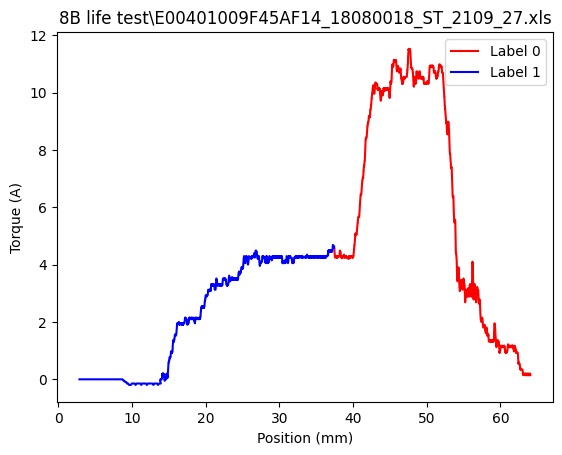

In [10]:
print(gm.means_,gm.means_.shape)
print(gm.covariances_,gm.covariances_.shape)
# Plot the signal
f,ax = plt.subplots()
pos = np.abs(data['Position (mm)'].values)
tq = data['I Torque (A)'].values
# iterate over the unique classes and mark the signal
for i,(label,mk) in enumerate(zip(np.unique(Y),['r','b'])):
    ax.plot(pos[Y==label],tq[Y==label],mk,label=f"Label {label}")
    # draw the gaussian distribution
    print(gm.means_[i,2])
ax.legend()
ax.set(xlabel="Position (mm)",ylabel="Torque (A)",title=path)

For a first guess, the predictions are generally pretty good. The split is approx where it transitions from first material to second material. There appears to be an offset from the "elbow" where it starts to go into the second material.

[Text(0.5, 0, 'File Index'),
 Text(0, 0.5, 'GMM First Class'),
 Text(0.5, 1.0, 'GMM First Class')]

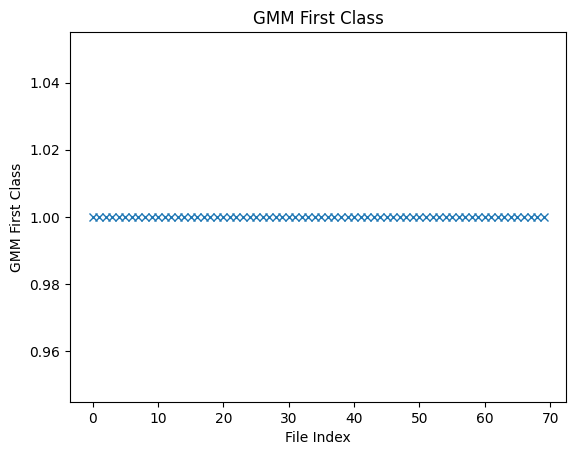

In [18]:
firstc = []
for i,fn in enumerate(sorted(glob("8B life test/*.xls"))):
    data = dp.loadSetitecXls(fn,version="auto_data")
    pos = np.abs(data['Position (mm)'].values)
    # using the raw signals as features
    # not using thrust empty as not all files have it
    X = np.column_stack((data['I Torque (A)'].values,
                     data['I Torque Empty (A)'].values,
                     pos,
                     data['I Thrust (A)'].values))
    # inititalize GMM for 2 components (materials)
    Y = GaussianMixture(n_components=2, random_state=0, max_iter=1000,covariance_type='spherical').fit_predict(X)
    firstc.append(Y[0])
f,ax = plt.subplots()
ax.plot(firstc,'x')
ax.set(xlabel="File Index",ylabel="GMM First Class",title="GMM First Class")


If we plot where either the first material ends or the second material begins we get the following distribution

[Text(0.5, 0, 'File Index'),
 Text(0, 0.5, 'Split Location (mm)'),
 Text(0.5, 1.0, 'Split Location using GMM nc=2')]

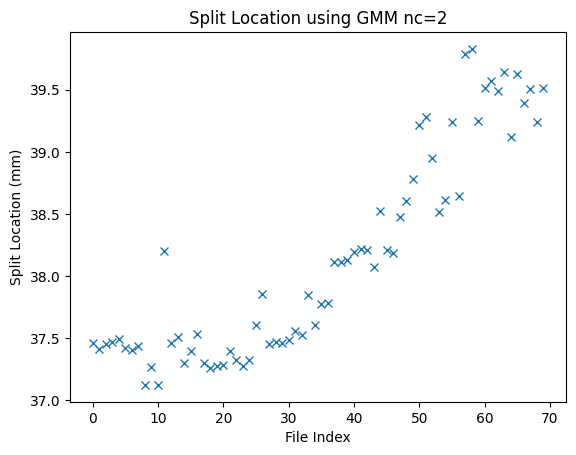

In [19]:
split = []
for fn in sorted(glob("8B life test/*.xls")):
    data = dp.loadSetitecXls(fn,version="auto_data")
    pos = np.abs(data['Position (mm)'].values)
    # using the raw signals as features
    # not using thrust empty as not all files have it
    X = np.column_stack((data['I Torque (A)'].values,
                     data['I Torque Empty (A)'].values,
                     pos,
                     data['I Thrust (A)'].values))
    # inititalize GMM for 2 components (materials)
    Y = GaussianMixture(n_components=2, random_state=0, max_iter=1000,covariance_type='spherical').fit_predict(X)
    # for some reason the index 1 tends to go first
    split.append(pos[np.where(Y==1)[0].max()])
f,ax = plt.subplots()
ax.plot(split,'x')
ax.set(xlabel="File Index",ylabel="Split Location (mm)",title="Split Location using GMM nc=2")

The covariance type seems to affect the distribution the most. The supported modes are ‘full’, ‘tied’, ‘diag’, ‘spherical’.

Adjusting reg_covar for model diag
Adjusting reg_covar for model diag
Adjusting reg_covar for model diag
Adjusting reg_covar for model diag
Adjusting reg_covar for model diag
Adjusting reg_covar for model diag
Adjusting reg_covar for model diag
Adjusting reg_covar for model diag
Adjusting reg_covar for model diag
Adjusting reg_covar for model diag
Adjusting reg_covar for model diag
Adjusting reg_covar for model diag
Adjusting reg_covar for model diag
Adjusting reg_covar for model diag
Adjusting reg_covar for model diag
Adjusting reg_covar for model diag
Adjusting reg_covar for model diag
Adjusting reg_covar for model diag
Adjusting reg_covar for model diag
Adjusting reg_covar for model diag
Adjusting reg_covar for model diag
Adjusting reg_covar for model diag
Adjusting reg_covar for model diag


[Text(0.5, 0, 'File Index'),
 Text(0, 0.5, 'Split Location (mm)'),
 Text(0.5, 1.0, 'Split Location using GMM nc=2')]

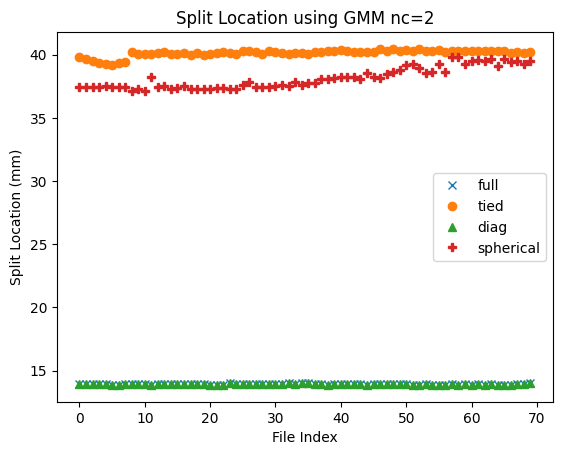

In [59]:
split = []
f,ax = plt.subplots()
# iterate over each supported model
for model,mk in zip(['full', 'tied', 'diag', 'spherical'],['x','o','^','P']):
    split.clear()
    # iterate ove each model
    for fn in sorted(glob("8B life test/*.xls")):
        # get data
        data = dp.loadSetitecXls(fn,version="auto_data")
        pos = np.abs(data['Position (mm)'].values)
        # using the raw signals as features
        # not using thrust empty as not all files have it
        X = np.column_stack((data['I Torque (A)'].values,
                        data['I Torque Empty (A)'].values,
                        pos,
                        data['I Thrust (A)'].values))
        # inititalize GMM for 2 components (materials)
        try:
            Y = GaussianMixture(n_components=2, random_state=0, max_iter=1000,covariance_type=model).fit_predict(X)
        # a common exception is it failing to converge and recommending increasing the number of components or increasing reg_covar
        except ValueError:
            print(f"Adjusting reg_covar for model {model}")
            # start as slightly above default (1e-6)
            regc = 2e-6
            # set an upper limit
            while regc<1e-4:
                try:
                    Y = GaussianMixture(n_components=2, random_state=0, max_iter=1000,covariance_type=model,reg_covar=regc).fit_predict(X)
                    break
                except ValueError:
                    # if it failed, increment by 1e-6
                    regc += 1e-6
            #print(f"Used {regc} as reg_covar for {fn}")
        # find which class label goes first by sorting medians
        # label 1 tends to go first, this is just insurance
        i = min(np.unique(Y),key=lambda c : np.median(pos[Y==c]))
        split.append(pos[np.where(Y==i)[0].max()])
    ax.plot(split,mk,label=model)
ax.legend()
ax.set(xlabel="File Index",ylabel="Split Location (mm)",title="Split Location using GMM nc=2")

Diagonal and Full generally has the same results or incredibly similar. Tied and Spherical are close to eachother. Plotting each model we can see the balance between the two classes.


Text(0.5, 0.98, '8B life test\\E00401009F45AF14_18080018_ST_2109_27.xls')

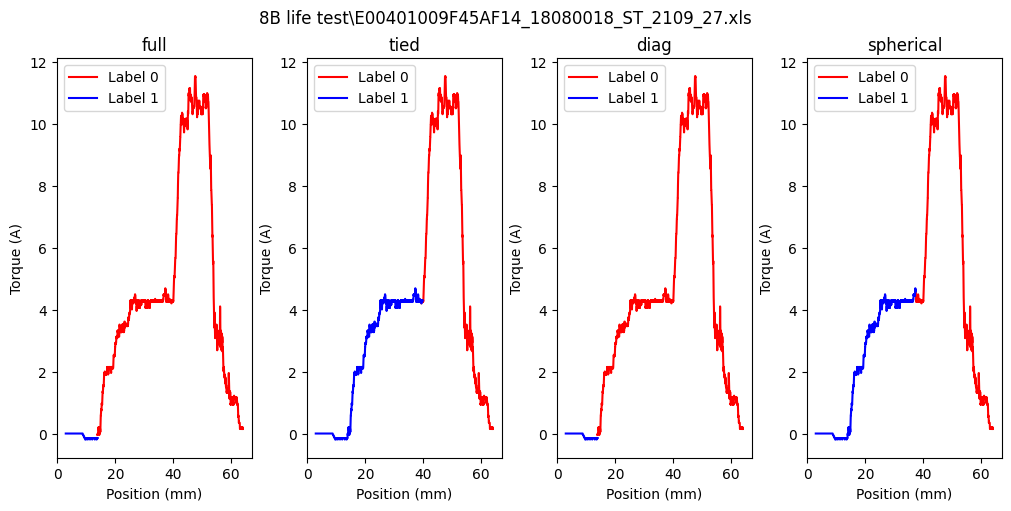

In [69]:
path = glob("8B life test/*.xls")[0]
data = dp.loadSetitecXls(path,version="auto_data")
pos = np.abs(data['Position (mm)'].values)
tq = data['I Torque (A)'].values
# using the raw signals as features
# not using thrust empty as not all files have it
X = np.column_stack((tq,
                    data['I Torque Empty (A)'].values,
                    pos,
                    data['I Thrust (A)'].values))
models = ['full', 'tied', 'diag', 'spherical']
# create axis for each model
f,ax = plt.subplots(ncols=len(models),constrained_layout=True,figsize=(10,5))
# iterate over models and axis
for aa,m in zip(ax.flatten(),models):
    try:
        Y = GaussianMixture(n_components=2, random_state=0, max_iter=1000,covariance_type=m).fit_predict(X)
    # a common exception is it failing to converge and recommending increasing the number of components or increasing reg_covar
    except ValueError:
        #print(f"Adjusting reg_covar for model {model}")
        # start as slightly above default (1e-6)
        regc = 2e-6
        # set an upper limit
        while regc<1e-4:
            try:
                Y = GaussianMixture(n_components=2, random_state=0, max_iter=1000,covariance_type=m,reg_covar=regc).fit_predict(X)
                break
            except ValueError:
                # if it failed, increment by 1e-6
                regc += 1e-6
    # draw each label
    for i,(label,mk) in enumerate(zip(np.unique(Y),['r','b'])):
        aa.plot(pos[Y==label],tq[Y==label],mk,label=f"Label {label}")
    aa.legend()
    aa.set(xlabel="Position (mm)",ylabel="Torque (A)",title=m)
f.suptitle(path)


Tied appears to perform slighlty better than Spherical

[Text(0.5, 0, 'File Index'),
 Text(0, 0.5, 'Split Location (mm)'),
 Text(0.5, 1.0, 'Split Location using GMM nc=2')]

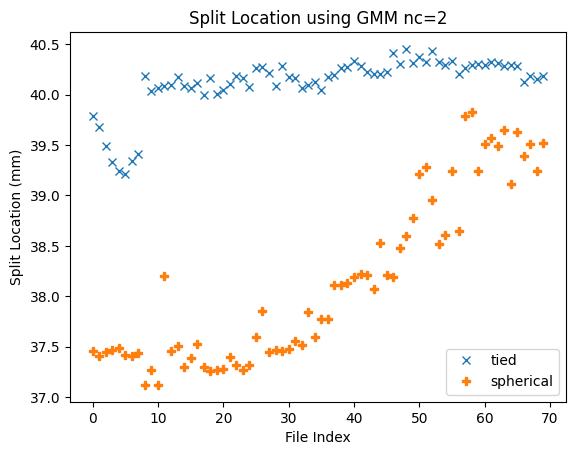

In [70]:
split = []
f,ax = plt.subplots()
# iterate over each supported model
for model,mk in zip(['tied','spherical'],['x','P']):
    split.clear()
    # iterate ove each model
    for fn in sorted(glob("8B life test/*.xls")):
        # get data
        data = dp.loadSetitecXls(fn,version="auto_data")
        pos = np.abs(data['Position (mm)'].values)
        # using the raw signals as features
        # not using thrust empty as not all files have it
        X = np.column_stack((data['I Torque (A)'].values,
                        data['I Torque Empty (A)'].values,
                        pos,
                        data['I Thrust (A)'].values))
        # inititalize GMM for 2 components (materials)
        try:
            Y = GaussianMixture(n_components=2, random_state=0, max_iter=1000,covariance_type=model).fit_predict(X)
        # a common exception is it failing to converge and recommending increasing the number of components or increasing reg_covar
        except ValueError:
            #print(f"Adjusting reg_covar for model {model}")
            # start as slightly above default (1e-6)
            regc = 2e-6
            # set an upper limit
            while regc<1e-4:
                try:
                    Y = GaussianMixture(n_components=2, random_state=0, max_iter=1000,covariance_type=model,reg_covar=regc).fit_predict(X)
                    break
                except ValueError:
                    # if it failed, increment by 1e-6
                    regc += 1e-6
            #print(f"Used {regc} as reg_covar for {fn}")
        # find which class label goes first by sorting medians
        # label 1 tends to go first, this is just insurance
        i = min(np.unique(Y),key=lambda c : np.median(pos[Y==c]))
        split.append(pos[np.where(Y==i)[0].max()])
    ax.plot(split,mk,label=model)
ax.legend()
ax.set(xlabel="File Index",ylabel="Split Location (mm)",title="Split Location using GMM nc=2")

Influence of Covariance regulator on the split location

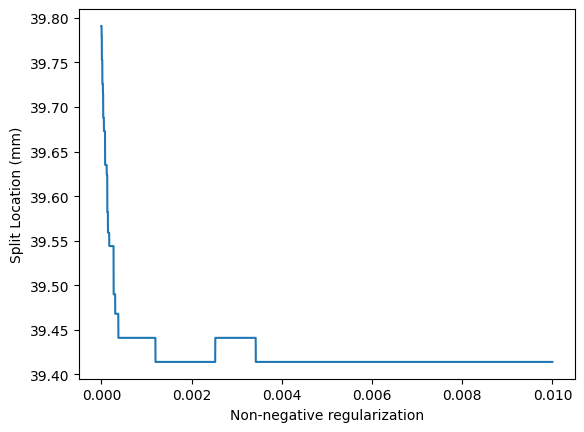

In [86]:
path = glob("8B life test/*.xls")[0]
data = dp.loadSetitecXls(path,version="auto_data")
pos = np.abs(data['Position (mm)'].values)
# using the raw signals as features
# not using thrust empty as not all files have it
X = np.column_stack((data['I Torque (A)'].values,
                    data['I Torque Empty (A)'].values,
                    pos,
                    data['I Thrust (A)'].values))
# inititalize GMM for 2 components (materials)
split = []
def find_split(rc):
    Y = GaussianMixture(n_components=2, random_state=0, max_iter=1000,covariance_type='tied',reg_covar=rc).fit_predict(X)
    i = min(np.unique(Y),key=lambda c : np.median(pos[Y==c]))
    return pos[np.where(Y==i)[0].max()]
rcs = np.arange(1e-10,1e-2,1e-6)
split = list(map(find_split,rcs))
f,ax = plt.subplots()
ax.set(xlabel="Non-negative regularization",ylabel="Split Location (mm)")
ax.plot(rcs,split)


Influence of Tolerance on split location

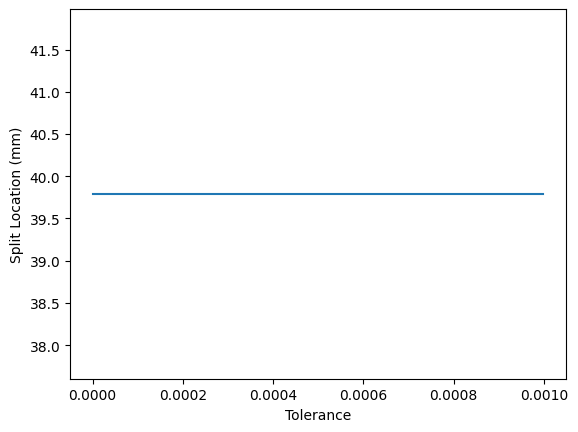

In [85]:
path = glob("8B life test/*.xls")[0]
data = dp.loadSetitecXls(path,version="auto_data")
pos = np.abs(data['Position (mm)'].values)
# using the raw signals as features
# not using thrust empty as not all files have it
X = np.column_stack((data['I Torque (A)'].values,
                    data['I Torque Empty (A)'].values,
                    pos,
                    data['I Thrust (A)'].values))
# inititalize GMM for 2 components (materials)
split = []
its = []
def find_split(rc):
    Y = GaussianMixture(n_components=2, random_state=0, max_iter=1000,covariance_type='tied',tol=rc).fit_predict(X)
    i = min(np.unique(Y),key=lambda c : np.median(pos[Y==c]))
    return pos[np.where(Y==i)[0].max()]
rcs = np.arange(1e-9,1e-3,1e-6)
split = list(map(find_split,rcs))
f,ax = plt.subplots()
ax.set(xlabel="Tolerance",ylabel="Split Location (mm)")
ax.plot(rcs,split)

#### More Components

Increasing the number of components might improve the fitting by handling unusual sections that would noticeable increase the size of fewer components.

[ 9  4 11  1  8  3  7  6 13  0 12 10  2 14  5] int64
[ 8.61     14.353    17.381    22.336    27.5095   32.650497 37.6245
 40.924    46.116    48.773    53.084    55.5635   57.9185   60.492
 63.252   ]


[Text(0.5, 0, 'Position (mm)'),
 Text(0, 0.5, 'Torque (A)'),
 Text(0.5, 1.0, '8B life test\\E00401009F45AF14_18080018_ST_2109_27.xls')]

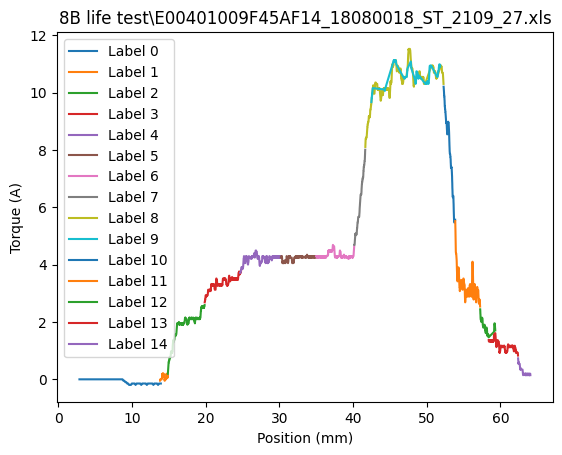

In [19]:
path = glob("8B life test/*.xls")[0]
data = dp.loadSetitecXls(path,version="auto_data")
pos = np.abs(data['Position (mm)'].values)
# sort labels to incrementing order
SORT_LABELS = True
# using the raw signals as features
# not using thrust empty as not all files have it
X = np.column_stack((data['I Torque (A)'].values,
                     data['I Torque Empty (A)'].values,
                     np.abs(data['Position (mm)'].values),
                     data['I Thrust (A)'].values))
# inititalize GMM for 2 components (materials)
Yo = GaussianMixture(n_components=15, random_state=0, max_iter=1000,covariance_type='tied').fit_predict(X)
if SORT_LABELS:
    ## sort the labels into increasing order
    # find the median of each class label
    med = np.array([np.median(pos[Yo==label]) for label in np.unique(Yo)])
    # find the sorted order
    ii = np.argsort(med)
    print(ii,ii.dtype)
    print(med[ii])
    # make a copy of the results
    Y = np.zeros(Yo.shape,dtype=Yo.dtype)
    for i,label in enumerate(np.unique(Yo)[ii]):
        Y[Yo==label] = i
else:
    Y = Yo
# plot the results
f,ax = plt.subplots()
tq = data['I Torque (A)'].values
# iterate over the unique classes and mark the signal
for label in np.unique(Y):
    ax.plot(pos[Y==label],tq[Y==label],label=f"Label {label}")
ax.legend()
ax.set(xlabel="Position (mm)",ylabel="Torque (A)",title=path)

Setting to 10 components gets very close to the areas we want, especially with model set to Tied. Logging where label 0, label 6 and label 11 ends.

processing spherical
processing tied


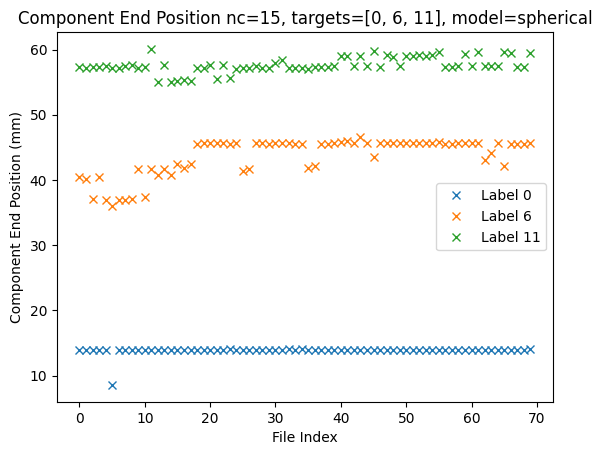

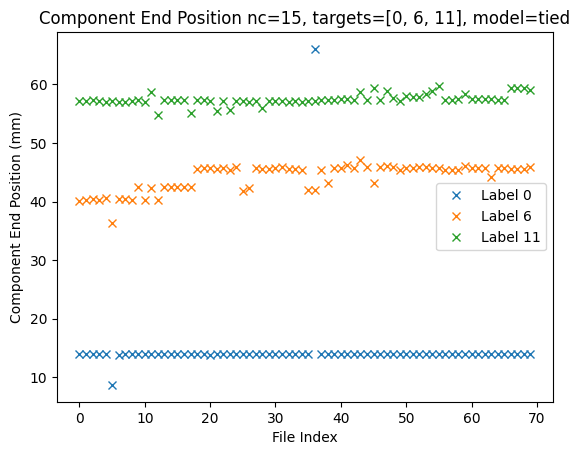

In [135]:
TARGET_CPS = [0,6,11]
MODELS = ['spherical','tied']
# dict to log component end pos
model_pos = {m : {tc : [] for tc in TARGET_CPS} for m in MODELS}
NC=15
for model in MODELS:
    end_pos = {tc : [] for tc in TARGET_CPS}
    print(f"processing {model}")
    for fn in glob("8B life test/*.xls"):
        # load the data
        data = dp.loadSetitecXls(fn,version="auto_data")
        pos = np.abs(data['Position (mm)'].values)
        # using the raw signals as features
        # not using thrust empty as not all files have it
        X = np.column_stack((data['I Torque (A)'].values,
                            data['I Torque Empty (A)'].values,
                            pos,
                            data['I Thrust (A)'].values))
        # reset the regulation covariance
        regc=1e-6
        while regc <= 1e-4:
            try:
                Yo = GaussianMixture(n_components=NC, random_state=0, max_iter=1000,covariance_type=model,reg_covar=regc).fit_predict(X)
                break
            except ValueError:
                # if it failed increment the value and try again
                regc += 1e-6
        # there's a weird issue where if the covariance_type is 'tied', the input size does not match the output
        # as a fix the last value is appended onto the end
        if Yo.shape[0] > pos.shape[0]:
            pos = np.append(pos,[pos[0],])
        elif Yo.shape[0] < pos.shape[0]:
            Yo = np.append(Yo,[Yo[0],])
        ## sort the labels into increasing order
        # find the sorted order
        ii = np.argsort(np.asarray([np.median(pos[Yo==label]) for label in np.unique(Yo)]))
        # make a copy of the results
        Y = np.zeros(Yo.shape,dtype=Yo.dtype)
        for i,label in enumerate(np.unique(Yo)[ii]):
            Y[Yo==label] = i
        # update dictionary
        for tc in TARGET_CPS:
            end_pos[tc].append(pos[Y==tc].max())
            model_pos[model][tc].append(pos[Y==tc].max())
    f,ax = plt.subplots()
    for k,v in end_pos.items():
        ax.plot(v,'x',label=f"Label {k}")
    ax.legend()
    ax.set(xlabel="File Index",ylabel="Component End Position (mm)",title=f"Component End Position nc={NC}, targets={TARGET_CPS}, model={model}")

The positions for *spherical* and *tied* are very similar suggesting this could work. Of course these results have not been validated yet so the focus of this plot is on the consistency of the values.

In [ ]:
import seaborn as sns
import pandas as pd
# re-arrange data into dataframe
cpid = np.concatenate([len()])

## Variational Bayesian Gaussian Mixture

### Two Components

[[ 9.09914994e+00  3.01872869e-01 -4.98562819e+00  9.75959698e-02]
 [ 3.01872869e-01  3.43102002e-01  1.53041491e+00  3.72145008e-03]
 [-4.98562819e+00  1.53041491e+00  6.10104757e+01 -1.05400992e-01]
 [ 9.75959698e-02  3.72145008e-03 -1.05400992e-01  1.32178211e-03]]
[[ 3.31512256e-01 -5.74836536e-02  1.01736667e-01 -6.75128086e-01]
 [ 0.00000000e+00  1.73269093e+00 -7.22576430e-01 -4.79748994e-01]
 [ 0.00000000e+00  0.00000000e+00  1.41926140e-01  7.47679942e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  6.82474934e+01]]


[Text(0.5, 0, 'Position (mm)'),
 Text(0, 0.5, 'Torque (A)'),
 Text(0.5, 1.0, '8B life test\\E00401009F45AF14_18080018_ST_2109_27.xls')]

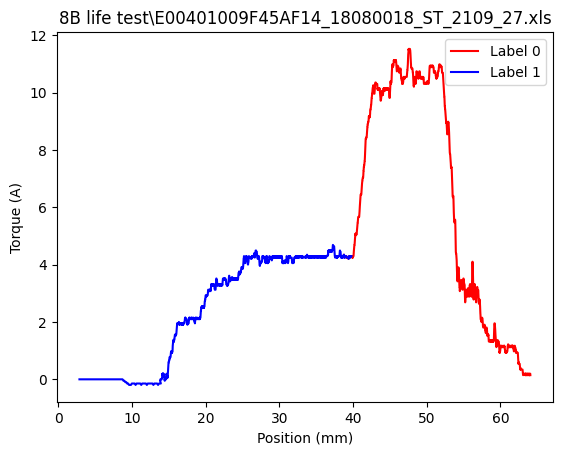

In [11]:
path = glob("8B life test/*.xls")[0]
data = dp.loadSetitecXls(path,version="auto_data")  
# using the raw signals as features
# not using thrust empty as not all files have it
X = np.column_stack((data['I Torque (A)'].values,
                     data['I Torque Empty (A)'].values,
                     np.abs(data['Position (mm)'].values),
                     data['I Thrust (A)'].values))
# inititalize GMM for 2 components (materials)
gm = BayesianGaussianMixture(n_components=2, random_state=0, max_iter=1000,
                            covariance_type='tied',
                            weight_concentration_prior_type='dirichlet_distribution').fit(X)
print(gm.covariances_)
print(gm.precisions_cholesky_)
Y = gm.predict(X)
# plot the results
f,ax = plt.subplots()
pos = np.abs(data['Position (mm)'].values)
tq = data['I Torque (A)'].values
# iterate over the unique classes and mark the signal
for label,mk in zip(np.unique(Y),['r','b','m','k']):
    ax.plot(pos[Y==label],tq[Y==label],mk,label=f"Label {label}")
ax.legend()
ax.set(xlabel="Position (mm)",ylabel="Torque (A)",title=path)

[Text(0.5, 0, 'File Index'),
 Text(0, 0.5, 'Split Location (mm)'),
 Text(0.5, 1.0, 'Split Location using BGMM nc=2')]

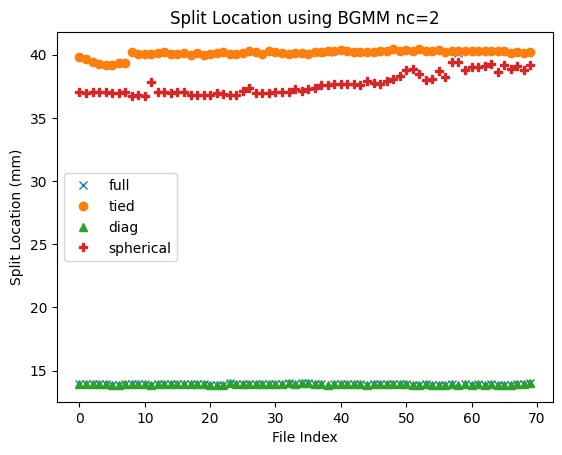

In [6]:
split = []
f,ax = plt.subplots()
# iterate over each supported model
for model,mk in zip(['full', 'tied', 'diag', 'spherical'],['x','o','^','P']):
    split.clear()
    # iterate ove each model
    for fn in sorted(glob("8B life test/*.xls")):
        # get data
        data = dp.loadSetitecXls(fn,version="auto_data")
        pos = np.abs(data['Position (mm)'].values)
        # using the raw signals as features
        # not using thrust empty as not all files have it
        X = np.column_stack((data['I Torque (A)'].values,
                        data['I Torque Empty (A)'].values,
                        pos,
                        data['I Thrust (A)'].values))
        # inititalize GMM for 2 components (materials)
        try:
            Y = BayesianGaussianMixture(n_components=2, random_state=0, max_iter=1000,
                            covariance_type=model,
                            weight_concentration_prior_type='dirichlet_distribution').fit_predict(X)
        # a common exception is it failing to converge and recommending increasing the number of components or increasing reg_covar
        except ValueError:
            print(f"Adjusting reg_covar for model {model}")
            # start as slightly above default (1e-6)
            regc = 2e-6
            # set an upper limit
            while regc<1e-4:
                try:
                    Y = GaussianMixture(n_components=2, random_state=0, max_iter=1000,covariance_type=model,reg_covar=regc).fit_predict(X)
                    break
                except ValueError:
                    # if it failed, increment by 1e-6
                    regc += 1e-6
            #print(f"Used {regc} as reg_covar for {fn}")
        # find which class label goes first by sorting medians
        # label 1 tends to go first, this is just insurance
        i = min(np.unique(Y),key=lambda c : np.median(pos[Y==c]))
        split.append(pos[np.where(Y==i)[0].max()])
    ax.plot(split,mk,label=model)
ax.legend()
ax.set(xlabel="File Index",ylabel="Split Location (mm)",title="Split Location using BGMM nc=2")

[Text(0.5, 0, 'File Index'),
 Text(0, 0.5, 'Split Location (mm)'),
 Text(0.5, 1.0, 'Split Location using BGMM nc=2')]

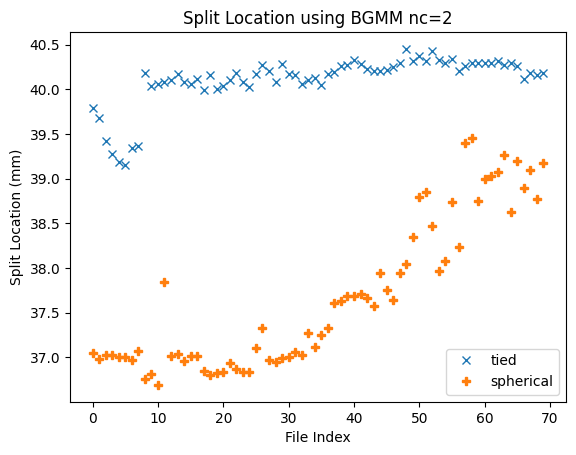

In [8]:
split = []
f,ax = plt.subplots()
# iterate over each supported model
for model,mk in zip(['tied','spherical'],['x','P']):
    split.clear()
    # iterate ove each model
    for fn in sorted(glob("8B life test/*.xls")):
        # get data
        data = dp.loadSetitecXls(fn,version="auto_data")
        pos = np.abs(data['Position (mm)'].values)
        # using the raw signals as features
        # not using thrust empty as not all files have it
        X = np.column_stack((data['I Torque (A)'].values,
                        data['I Torque Empty (A)'].values,
                        pos,
                        data['I Thrust (A)'].values))
        # inititalize GMM for 2 components (materials)
        try:
            Y = BayesianGaussianMixture(n_components=2, random_state=0, max_iter=1000,
                            covariance_type=model,
                            weight_concentration_prior_type='dirichlet_distribution').fit_predict(X)
        # a common exception is it failing to converge and recommending increasing the number of components or increasing reg_covar
        except ValueError:
            #print(f"Adjusting reg_covar for model {model}")
            # start as slightly above default (1e-6)
            regc = 2e-6
            # set an upper limit
            while regc<1e-4:
                try:
                    Y = GaussianMixture(n_components=2, random_state=0, max_iter=1000,covariance_type=model,reg_covar=regc).fit_predict(X)
                    break
                except ValueError:
                    # if it failed, increment by 1e-6
                    regc += 1e-6
            #print(f"Used {regc} as reg_covar for {fn}")
        # find which class label goes first by sorting medians
        # label 1 tends to go first, this is just insurance
        i = min(np.unique(Y),key=lambda c : np.median(pos[Y==c]))
        split.append(pos[np.where(Y==i)[0].max()])
    ax.plot(split,mk,label=model)
ax.legend()
ax.set(xlabel="File Index",ylabel="Split Location (mm)",title="Split Location using BGMM nc=2")

### More Components

(3953, 4)
(3953,) (3953,) int64
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
      dtype=int64), array([225, 389,  49, 281,  79, 149, 114, 446, 449,  91, 262, 379,  76,
       592, 372], dtype=int64))
[ 9  4 11  1  8  3  7  6 13  0 12  2 10 14  5] int64
[ 8.61   14.342  17.322  22.321  27.775  32.527  37.2595 40.9045 46.099
 48.773  52.7775 53.593  55.6155 59.7435 63.134 ]


[Text(0.5, 0, 'Position (mm)'),
 Text(0, 0.5, 'Torque (A)'),
 Text(0.5, 1.0, '8B life test\\E00401009F45AF14_18080018_ST_2109_27.xls')]

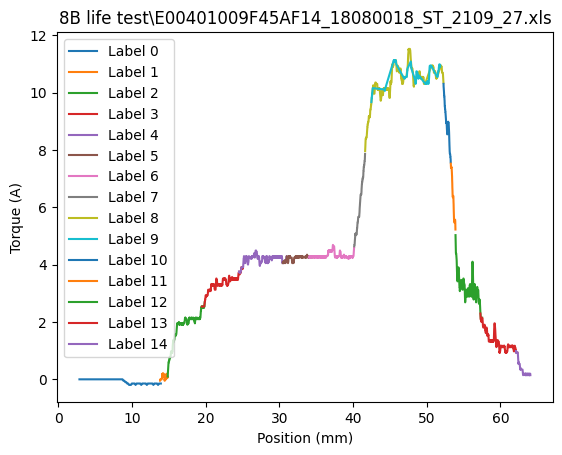

In [21]:
path = glob("8B life test/*.xls")[0]
data = dp.loadSetitecXls(path,version="auto_data")
pos = np.abs(data['Position (mm)'].values)
# sort labels to incrementing order
SORT_LABELS = True
# using the raw signals as features
# not using thrust empty as not all files have it
X = np.column_stack((data['I Torque (A)'].values,
                     data['I Torque Empty (A)'].values,
                     np.abs(data['Position (mm)'].values),
                     data['I Thrust (A)'].values))
print(X.shape)
# inititalize GMM for 2 components (materials)
Yo = BayesianGaussianMixture(n_components=15, random_state=0, max_iter=1000,
                            covariance_type="tied",
                            weight_concentration_prior_type='dirichlet_distribution').fit_predict(X)
print(data['I Torque (A)'].values.shape,Yo.shape,Yo.dtype)
print(np.unique(Yo,return_counts=True))
if SORT_LABELS:
    ## sort the labels into increasing order
    # find the median of each class label
    med = np.array([np.median(pos[Yo==label]) for label in np.unique(Yo)])
    # find the sorted order
    ii = np.argsort(med)
    print(ii,ii.dtype)
    print(med[ii])
    # make a copy of the results
    Y = np.zeros(Yo.shape,dtype=Yo.dtype)
    for i,label in enumerate(np.unique(Yo)[ii]):
        Y[Yo==label] = i
else:
    Y = Yo
# plot the results
f,ax = plt.subplots()
tq = data['I Torque (A)'].values
# iterate over the unique classes and mark the signal
for label in np.unique(Y):
    ax.plot(pos[Y==label],tq[Y==label],label=f"Label {label}")
ax.legend()
ax.set(xlabel="Position (mm)",ylabel="Torque (A)",title=path)

processing spherical
processing tied


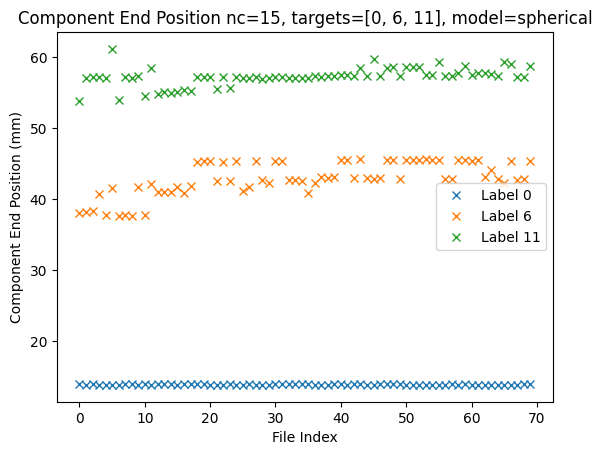

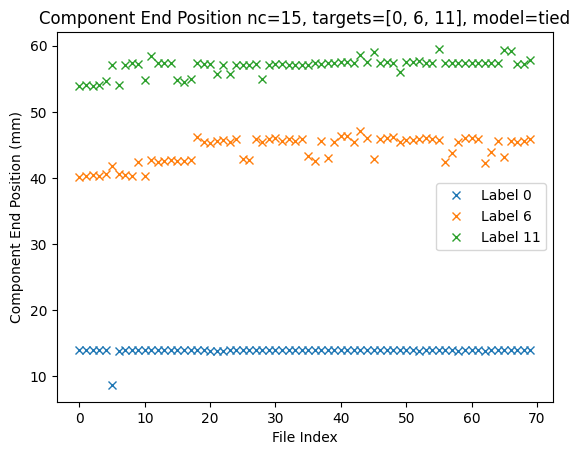

In [22]:
TARGET_CPS = [0,6,11]
MODELS = ['spherical','tied']
# dict to log component end pos
model_pos = {m : {tc : [] for tc in TARGET_CPS} for m in MODELS}
NC=15
for model in MODELS:
    end_pos = {tc : [] for tc in TARGET_CPS}
    print(f"processing {model}")
    for fn in glob("8B life test/*.xls"):
        # load the data
        data = dp.loadSetitecXls(fn,version="auto_data")
        pos = np.abs(data['Position (mm)'].values)
        # using the raw signals as features
        # not using thrust empty as not all files have it
        X = np.column_stack((data['I Torque (A)'].values,
                            data['I Torque Empty (A)'].values,
                            pos,
                            data['I Thrust (A)'].values))
        # reset the regulation covariance
        regc=1e-6
        while regc <= 1e-4:
            try:
                Yo = BayesianGaussianMixture(n_components=15, random_state=0, max_iter=1000,
                            covariance_type=model,
                            weight_concentration_prior_type='dirichlet_distribution').fit_predict(X)
                break
            except ValueError:
                # if it failed increment the value and try again
                regc += 1e-6
        # there's a weird issue where if the covariance_type is 'tied', the input size does not match the output
        # as a fix the last value is appended onto the end
        if Yo.shape[0] > pos.shape[0]:
            pos = np.append(pos,[pos[0],])
        elif Yo.shape[0] < pos.shape[0]:
            Yo = np.append(Yo,[Yo[0],])
        ## sort the labels into increasing order
        # find the sorted order
        ii = np.argsort(np.asarray([np.median(pos[Yo==label]) for label in np.unique(Yo)]))
        # make a copy of the results
        Y = np.zeros(Yo.shape,dtype=Yo.dtype)
        for i,label in enumerate(np.unique(Yo)[ii]):
            Y[Yo==label] = i
        # update dictionary
        for tc in TARGET_CPS:
            end_pos[tc].append(pos[Y==tc].max())
            model_pos[model][tc].append(pos[Y==tc].max())
    f,ax = plt.subplots()
    for k,v in end_pos.items():
        ax.plot(v,'x',label=f"Label {k}")
    ax.legend()
    ax.set(xlabel="File Index",ylabel="Component End Position (mm)",title=f"Component End Position nc={NC}, targets={TARGET_CPS}, model={model}")

# Investigating the features

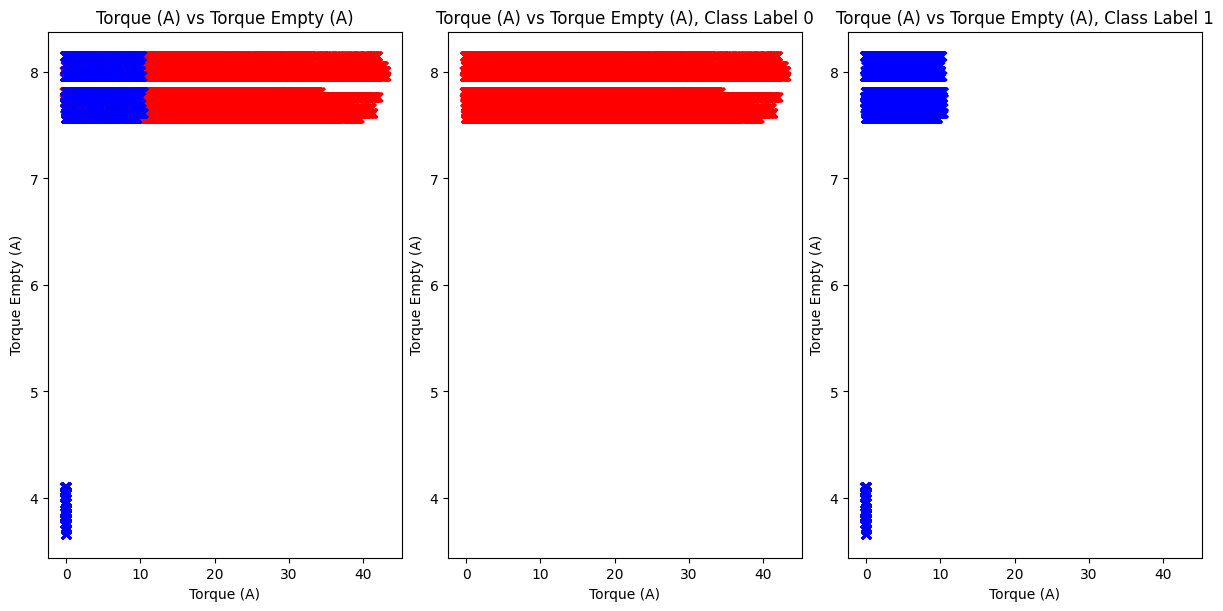

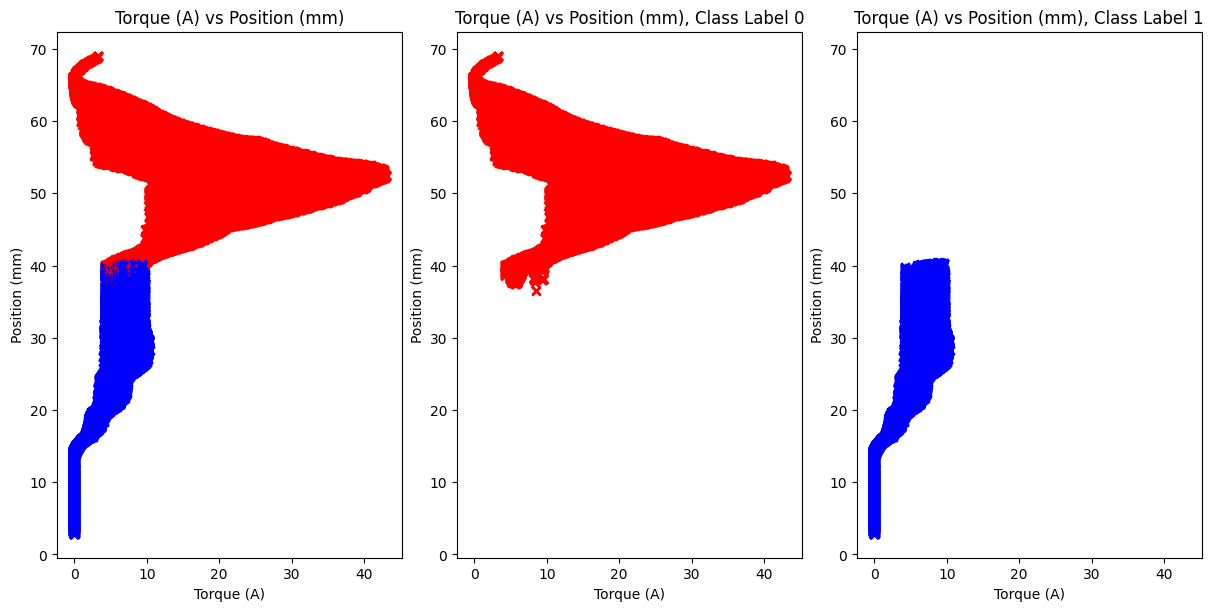

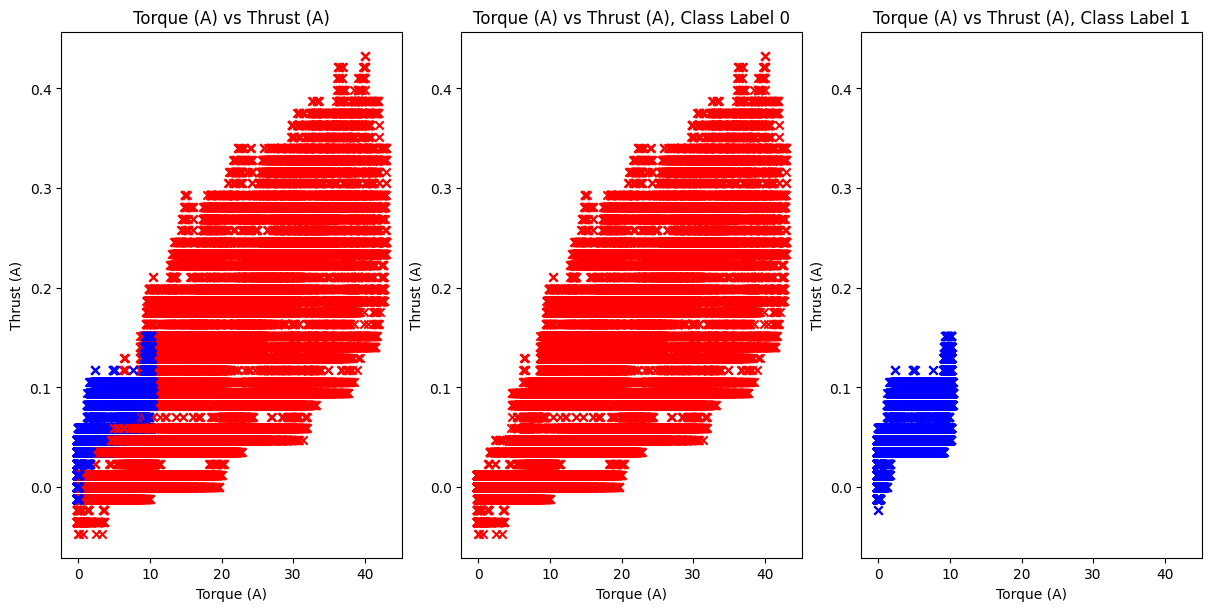

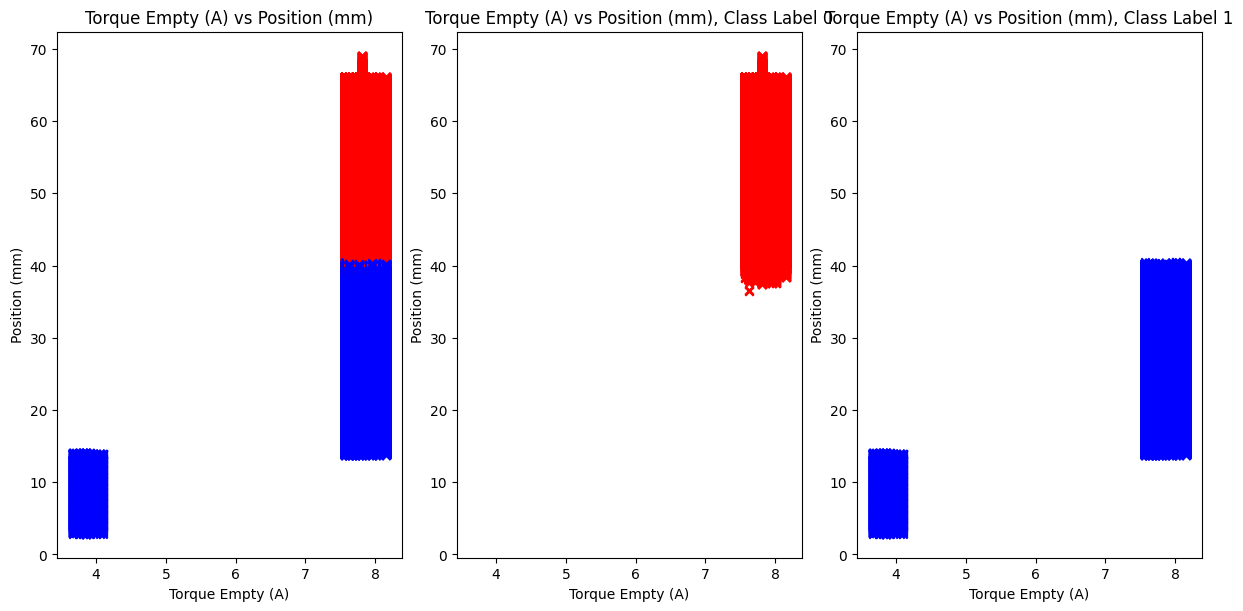

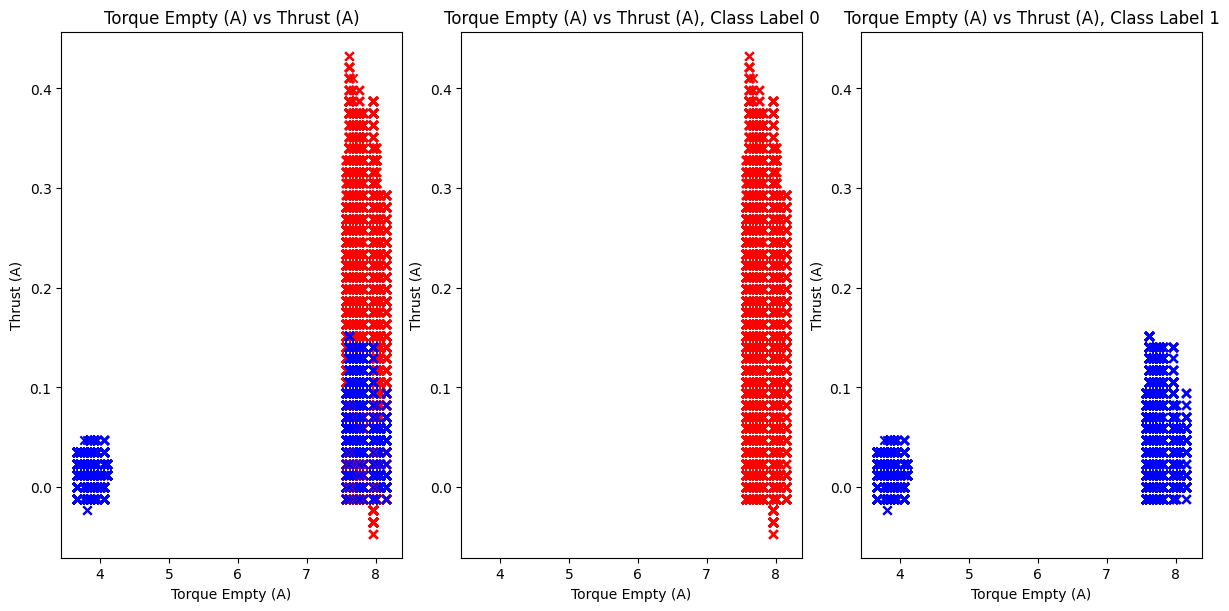

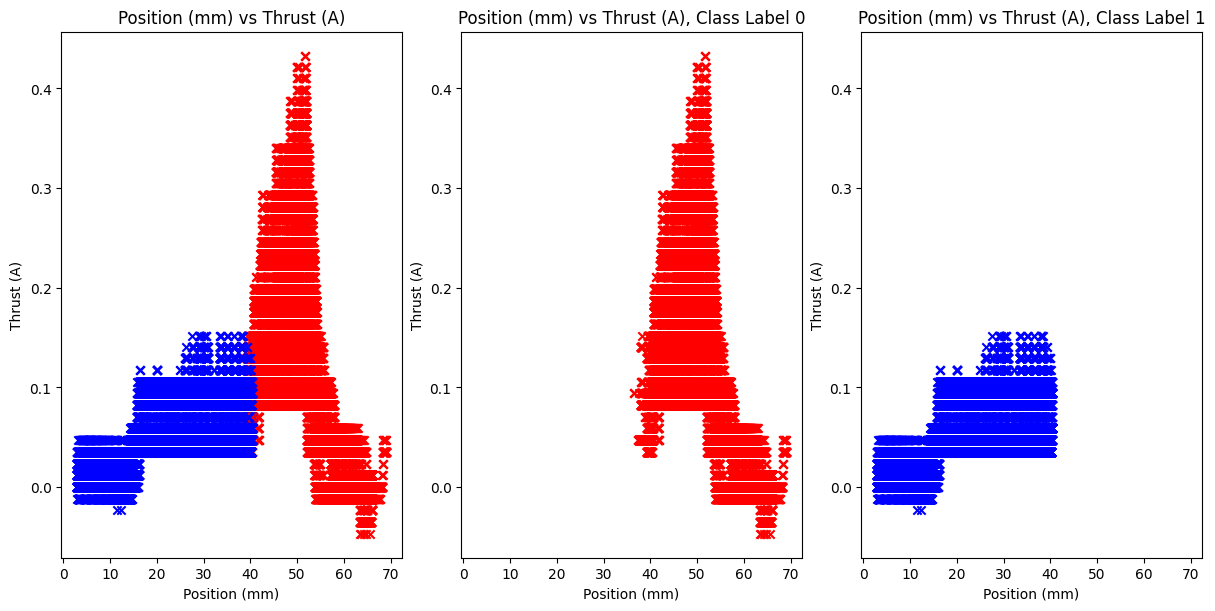

In [36]:
from itertools import combinations
X = {'Torque (A)':[],'Torque Empty (A)':[],'Position (mm)':[],'Thrust (A)':[]}
YY = []
COLS = ['r','b']
# assemble values
for fn in glob("8B life test/*.xls"):
    # load the data
    data = dp.loadSetitecXls(fn,version="auto_data")
    # arranging data into 
    X['Torque (A)'].append(data['I Torque (A)'].values)
    X['Torque Empty (A)'].append(data['I Torque Empty (A)'].values)
    X['Position (mm)'].append(np.abs(data['Position (mm)'].values))
    X['Thrust (A)'].append(data['I Thrust (A)'].values)

    XX = np.column_stack((data['I Torque (A)'].values,
                     data['I Torque Empty (A)'].values,
                     np.abs(data['Position (mm)'].values),
                     data['I Thrust (A)'].values))
    Y = GaussianMixture(n_components=2, random_state=0, max_iter=1000,covariance_type='tied',reg_covar=1e-6).fit_predict(XX)
    YY.append(Y)
# iterations of combinations of features
for kA,kB in combinations(X.keys(),2):
    f,ax = plt.subplots(ncols=3,constrained_layout=True,figsize=(12,6))
    # get the feature vectors
    A = X[kA]
    B = X[kB]
    # plot features marking by class and color
    # labels are 0 or 1
    for a,b,y in zip(A,B,YY):
        ax[0].scatter(a[y==0],b[y==0],c=COLS[0],marker='x')
        ax[0].scatter(a[y==1],b[y==1],c=COLS[1],marker='x')
        ylim = ax[0].get_ylim()
        xlim = ax[0].get_xlim()
        
        ax[1].scatter(a[y==0],b[y==0],c=COLS[0],marker='x')
        ax[1].set_ylim(ylim)
        ax[1].set_xlim(xlim)
        
        ax[2].scatter(a[y==1],b[y==1],c=COLS[1],marker='x')
        ax[2].set_ylim(ylim)
        ax[2].set_xlim(xlim)

        ax[0].set(xlabel=kA,ylabel=kB,title=f"{kA} vs {kB}")
        ax[1].set(xlabel=kA,ylabel=kB,title=f"{kA} vs {kB}, Class Label 0")
        ax[2].set(xlabel=kA,ylabel=kB,title=f"{kA} vs {kB}, Class Label 1")
        

## Two-tier Approach

Both the regular and variantional versions of the Gaussian Mixture Models are producing similar results. Unfortunately, the higher number of components doesn't quite line up the best. A two tier approach could be to split in two and then split each class independently.

pos  (4108,)
X  (4108, 4)
Y  (4108,)
Y labels  [0 1]
num res sections  4
res comb shape  (4108,)
res labels  [1 2 3]


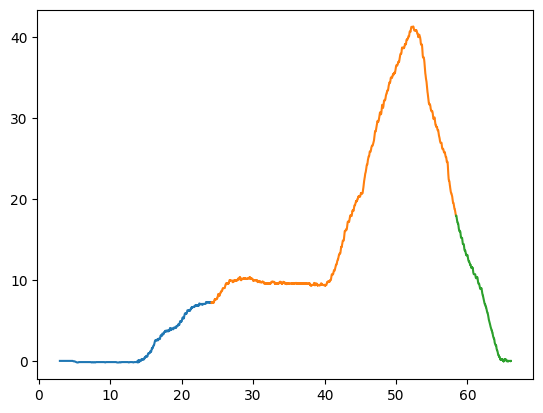

In [87]:
LEVELS=2
path = glob("8B life test/*.xls")[0]
pos = np.abs(data['Position (mm)'].values)
X = np.column_stack((data['I Torque (A)'].values,
    data['I Torque Empty (A)'].values,
    pos,
    data['I Thrust (A)'].values))
# perform intial split into two
#Y = GaussianMixture(n_components=NC, random_state=0, max_iter=1000,covariance_type="tied",reg_covar=1e-6).fit_predict(X)
regc=1e-6
while regc <= 1e-4:
    try:
        Y = GaussianMixture(n_components=2, random_state=0, max_iter=1000,covariance_type="tied",reg_covar=regc).fit_predict(X)
        break
    except ValueError:
        # if it failed increment the value and try again
        regc += 1e-6
print("pos ",pos.shape)
print("X ",X.shape)
print("Y ",Y.shape)
print("Y labels ",np.unique(Y))
res = []
# for each label
o = 0
for i,yy in zip(range(len(np.unique(Y))),np.unique(Y)):
    # filter
    A = X[Y==yy,:]
    # split
    #Z = GaussianMixture(n_components=NC, random_state=0, max_iter=1000,covariance_type="tied",reg_covar=1e-5).fit_predict(A)
    regc=1e-6
    while regc <= 1e-4:
        try:
            Z = GaussianMixture(n_components=2, random_state=0, max_iter=1000,covariance_type="tied",reg_covar=regc).fit_predict(A)
            break
        except ValueError:
            # if it failed increment the value and try again
            regc += 1e-6
    # increment to ensure unique global labels
    Z += i+o
    # append results to global list
    for ll in np.unique(Z):
        res.append(Z[Z==ll])
    o+=2

print("num res sections ",len(res))
res = np.concatenate(res)
print("res comb shape ",res.shape)
print("res labels ",np.unique(res))
f,ax = plt.subplots()
for ll in np.unique(res):
    ax.plot(pos[res==ll],data['I Torque (A)'].values[res==ll])


# Combo Approach

In general, the covariance models either split the signal around the middle of the signal or early in the signal towards the start. Combining these two behaviours could improve the overall picture.

[Text(0.5, 0, 'Position (mm)'),
 Text(0, 0.5, 'Torque (A)'),
 Text(0.5, 1.0, 'combined')]

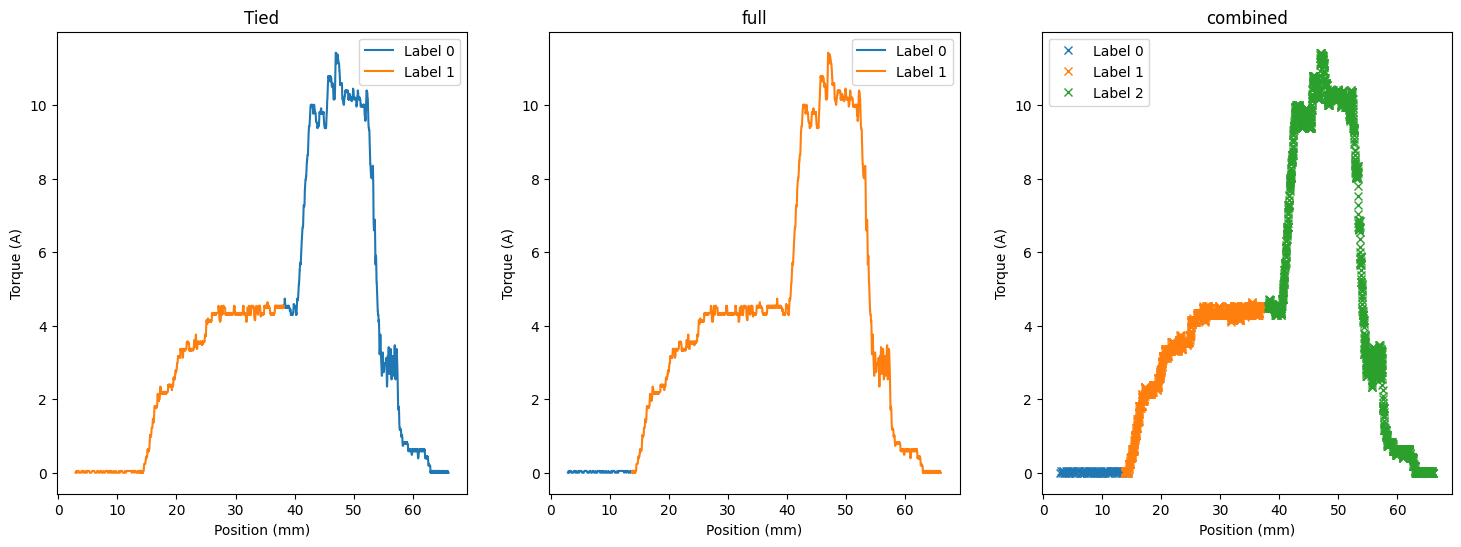

In [47]:
path = glob("8B random life test/*.xls")[0]
data = dp.loadSetitecXls(path,version="auto_data")  
pos = np.abs(data['Position (mm)'].values)
tq = data['I Torque (A)'].values
# using the raw signals as features
# not using thrust empty as not all files have it
X = np.column_stack((data['I Torque (A)'].values,
                     data['I Torque Empty (A)'].values,
                     np.abs(data['Position (mm)'].values),
                     data['I Thrust (A)'].values))
# inititalize GMM for 2 components (materials)
YA = GaussianMixture(n_components=2, random_state=0, max_iter=1000,covariance_type='spherical',reg_covar=1e-6).fit_predict(X)
f,ax = plt.subplots(ncols=3,figsize=(6*3,6))
# iterate over the unique classes and mark the signal
for label in np.unique(YA):
    ax[0].plot(pos[YA==label],tq[YA==label],label=f"Label {label}")
ax[0].legend()
ax[0].set(xlabel="Position (mm)",ylabel="Torque (A)",title="Tied")
# label 0 of tied is the 2nd half of the signal
# label 1 is the early portion of air
YB = GaussianMixture(n_components=2, random_state=0, max_iter=1000,covariance_type='full',reg_covar=1e-6).fit_predict(X)

## post process to ensure labels are positively increasing 0 -> 1
if YA[0] ==1:
    YA=(~YA.astype("bool")).astype(np.int64)
if YB[0] == 1:
    YB=(~YB.astype("bool")).astype(np.int64)

# iterate over the unique classes and mark the signal
for label in np.unique(YB):
    ax[1].plot(pos[YB==label],tq[YB==label],label=f"Label {label}")
ax[1].legend()
ax[1].set(xlabel="Position (mm)",ylabel="Torque (A)",title="full")

# label 1 is the early part of the signal and label 0 is the later part
## marking labels
labels = np.zeros(X.shape[0],dtype=np.int64)
labels[YB==0] = 0
labels[YA==1] = 2
labels[(YB!=0)&(YA!=1)] = 1
for uq in np.unique(labels):
    ax[2].plot(pos[labels==uq],tq[labels==uq],'x',label=f"Label {uq}")
ax[2].legend()
ax[2].set(xlabel="Position (mm)",ylabel="Torque (A)",title="combined")

There appears to be an issue with occasionally single samples of a label being interdispersed within other labels. The following block of code shows which files had overlap for either spherical or tied in the first stage.

[Text(0.5, 0, 'File Index'),
 Text(0, 0.5, 'Has Overlap'),
 Text(0.5, 1.0, '8B random life test')]

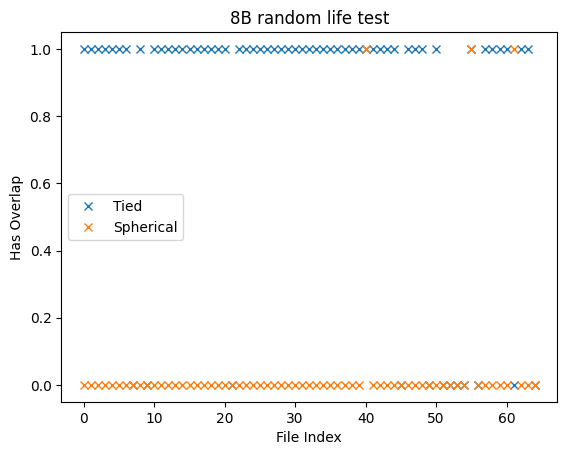

In [52]:
tied_overlap = []
spherical_overlap = []
for fn in glob("8B random life test/*.xls"):
    data = dp.loadSetitecXls(fn,version="auto_data")  
    pos = np.abs(data['Position (mm)'].values)
    tq = data['I Torque (A)'].values
    # using the raw signals as features
    # not using thrust empty as not all files have it
    X = np.column_stack((data['I Torque (A)'].values,
                        data['I Torque Empty (A)'].values,
                        np.abs(data['Position (mm)'].values),
                        data['I Thrust (A)'].values))
    # inititalize GMM for 2 components (materials)
    YA = GaussianMixture(n_components=2, random_state=0, max_iter=1000,covariance_type='spherical',reg_covar=1e-6).fit_predict(X)
    # label 0 of tied is the 2nd half of the signal
    # label 1 is the early portion of air
    YB = GaussianMixture(n_components=2, random_state=0, max_iter=1000,covariance_type='full',reg_covar=1e-6).fit_predict(X)
    ## post process to ensure labels are positively increasing 0 -> 1
    if YA[0] ==1:
        YA=(~YA.astype("bool")).astype(np.int64)
    if YB[0] == 1:
        YB=(~YB.astype("bool")).astype(np.int64)
    labels = np.zeros(X.shape[0],dtype=np.int64)
    labels[YB==0] = 0
    labels[YA==1] = 2
    labels[(YB!=0)&(YA!=1)] = 1
    diff = np.diff(labels)
    spherical_overlap.append(int((diff==-1).any()))

    YA = GaussianMixture(n_components=2, random_state=0, max_iter=1000,covariance_type='tied',reg_covar=1e-6).fit_predict(X)
    # label 0 of tied is the 2nd half of the signal
    # label 1 is the early portion of air
    YB = GaussianMixture(n_components=2, random_state=0, max_iter=1000,covariance_type='full',reg_covar=1e-6).fit_predict(X)
    ## post process to ensure labels are positively increasing 0 -> 1
    if YA[0] ==1:
        YA=(~YA.astype("bool")).astype(np.int64)
    if YB[0] == 1:
        YB=(~YB.astype("bool")).astype(np.int64)
    labels = np.zeros(X.shape[0],dtype=np.int64)
    labels[YB==0] = 0
    labels[YA==1] = 2
    labels[(YB!=0)&(YA!=1)] = 1
    diff = np.diff(labels)
    tied_overlap.append(int((diff==-1).any()))

f,ax = plt.subplots()
ax.plot(tied_overlap,'x',label="Tied")
ax.plot(spherical_overlap,'x',label="Spherical")
ax.legend()
ax.set(xlabel="File Index",ylabel="Has Overlap",title=os.path.dirname(fn))

One approach to solving the overlapping issue is applying a filling operation where the min and max index of a given label is filled with that label.

False


[Text(0.5, 0, 'Position (mm)'),
 Text(0, 0.5, 'Torque (A)'),
 Text(0.5, 1.0, 'combined (split)')]

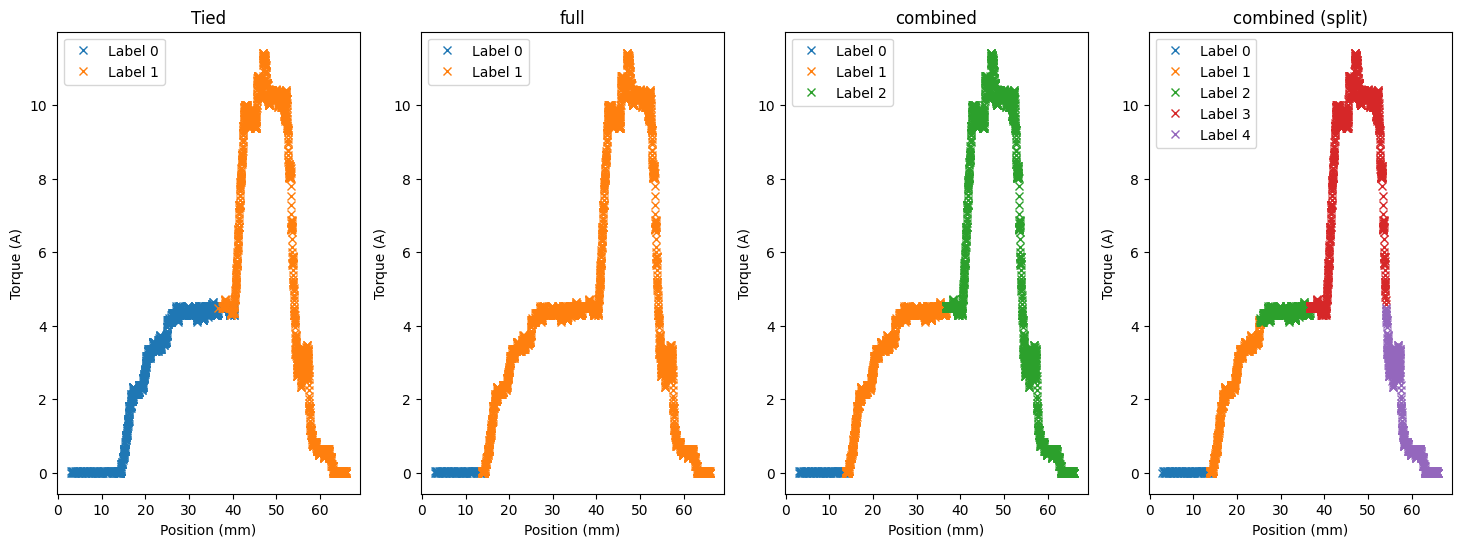

In [23]:
path = glob("8B random life test/*.xls")[0]
data = dp.loadSetitecXls(path,version="auto_data")  
pos = np.abs(data['Position (mm)'].values)
tq = data['I Torque (A)'].values
# using the raw signals as features
# not using thrust empty as not all files have it
X = np.column_stack((data['I Torque (A)'].values,
                     data['I Torque Empty (A)'].values,
                     np.abs(data['Position (mm)'].values),
                     data['I Thrust (A)'].values))
# inititalize GMM for 2 components (materials)
YA = GaussianMixture(n_components=2, random_state=0, max_iter=1000,covariance_type='tied',reg_covar=1e-6).fit_predict(X)
# label 0 of tied is the 2nd half of the signal
# label 1 is the early portion of air
YB = GaussianMixture(n_components=2, random_state=0, max_iter=1000,covariance_type='full',reg_covar=1e-6).fit_predict(X)

def fill_lablels(labels):
    # apply a filling operation
    labels_fix = np.copy(labels)
    for uq in np.unique(labels_fix):
        ii = np.where(labels_fix==uq)[0]
        labels[ii.min():ii.max()] = uq
    return labels

## post process to ensure labels are positively increasing 0 -> 1
if YA[0] ==1:
    YA=(~YA.astype("bool")).astype(np.int64)
if YB[0] == 1:
    YB=(~YB.astype("bool")).astype(np.int64)

f,ax = plt.subplots(ncols=4,figsize=(6*3,6))
# iterate over the unique classes and mark the signal
for label in np.unique(YA):
    ax[0].plot(pos[YA==label],tq[YA==label],'x',label=f"Label {label}")
ax[0].legend()
ax[0].set(xlabel="Position (mm)",ylabel="Torque (A)",title="Tied")

# iterate over the unique classes and mark the signal
for label in np.unique(YB):
    ax[1].plot(pos[YB==label],tq[YB==label],'x',label=f"Label {label}")
ax[1].legend()
ax[1].set(xlabel="Position (mm)",ylabel="Torque (A)",title="full")

# label 1 is the early part of the signal and label 0 is the later part
## marking labels
labels = np.zeros(X.shape[0],dtype=np.int64)
labels[YB==0] = 0
labels[YA==1] = 2
labels[(YB!=0)&(YA!=1)] = 1

#for uq in np.unique(labels):
#    ax[2].plot(pos[labels==uq],tq[labels==uq],'x',label=f"Label {uq}")
#ax[2].legend()
#ax[2].set(xlabel="Position (mm)",ylabel="Torque (A)",title="combined")

# apply a filling operation
labels = fill_lablels(labels)
# plot the fixed labels
for uq in np.unique(labels):
    ax[2].plot(pos[labels==uq],tq[labels==uq],'x',label=f"Label {uq}")
ax[2].legend()
ax[2].set(xlabel="Position (mm)",ylabel="Torque (A)",title="combined")
print((np.diff(labels)==-1).any())

# before splitting first label increment last label to avoid corruption
lm = labels.max()
labels[labels==lm] = lm+1

# split label 1
XX = X[labels==1,:]
YC = GaussianMixture(n_components=2, random_state=0, max_iter=1000,covariance_type='full',reg_covar=1e-6).fit_predict(XX)
# force increasing order
if YC[0] ==1:
    YC=(~YC.astype("bool")).astype(np.int64)
YC = fill_lablels(YC)+1
labels[labels==1] = YC

# split label 2
XX = X[labels==3,:]
YC = GaussianMixture(n_components=2, random_state=0, max_iter=1000,covariance_type='spherical',reg_covar=1e-6).fit_predict(XX)
# force increasing order
if YC[0] ==1:
    YC=(~YC.astype("bool")).astype(np.int64)
YC = fill_lablels(YC)+2+1
labels[labels==3] = YC

for uq in np.unique(labels):
    ax[3].plot(pos[labels==uq],tq[labels==uq],'x',label=f"Label {uq}")
ax[3].legend()
ax[3].set(xlabel="Position (mm)",ylabel="Torque (A)",title="combined (split)")

Section for saving the results

In [24]:
OPATH = "gmm-combo-split"
for path in glob("8B random life test/*.xls"):
    data = dp.loadSetitecXls(path,version="auto_data")  
    pos = np.abs(data['Position (mm)'].values)
    tq = data['I Torque (A)'].values
    # using the raw signals as features
    # not using thrust empty as not all files have it
    X = np.column_stack((data['I Torque (A)'].values,
                        data['I Torque Empty (A)'].values,
                        np.abs(data['Position (mm)'].values),
                        data['I Thrust (A)'].values))
    # inititalize GMM for 2 components (materials)
    YA = GaussianMixture(n_components=2, random_state=0, max_iter=1000,covariance_type='tied',reg_covar=1e-6).fit_predict(X)
    # label 0 of tied is the 2nd half of the signal
    # label 1 is the early portion of air
    YB = GaussianMixture(n_components=2, random_state=0, max_iter=1000,covariance_type='full',reg_covar=1e-6).fit_predict(X)

    def fill_lablels(labels):
        # apply a filling operation
        labels_fix = np.copy(labels)
        for uq in np.unique(labels_fix):
            ii = np.where(labels_fix==uq)[0]
            labels[ii.min():ii.max()] = uq
        return labels

    ## post process to ensure labels are positively increasing 0 -> 1
    if YA[0] ==1:
        YA=(~YA.astype("bool")).astype(np.int64)
    if YB[0] == 1:
        YB=(~YB.astype("bool")).astype(np.int64)

    f,ax = plt.subplots(ncols=4,figsize=(6*3,6))
    # iterate over the unique classes and mark the signal
    for label in np.unique(YA):
        ax[0].plot(pos[YA==label],tq[YA==label],'x',label=f"Label {label}")
    ax[0].legend()
    ax[0].set(xlabel="Position (mm)",ylabel="Torque (A)",title="Tied")

    # iterate over the unique classes and mark the signal
    for label in np.unique(YB):
        ax[1].plot(pos[YB==label],tq[YB==label],'x',label=f"Label {label}")
    ax[1].legend()
    ax[1].set(xlabel="Position (mm)",ylabel="Torque (A)",title="full")

    # label 1 is the early part of the signal and label 0 is the later part
    ## marking labels
    labels = np.zeros(X.shape[0],dtype=np.int64)
    labels[YB==0] = 0
    labels[YA==1] = 2
    labels[(YB!=0)&(YA!=1)] = 1

    #for uq in np.unique(labels):
    #    ax[2].plot(pos[labels==uq],tq[labels==uq],'x',label=f"Label {uq}")
    #ax[2].legend()
    #ax[2].set(xlabel="Position (mm)",ylabel="Torque (A)",title="combined")

    # apply a filling operation
    labels = fill_lablels(labels)
    # plot the fixed labels
    for uq in np.unique(labels):
        ax[2].plot(pos[labels==uq],tq[labels==uq],'x',label=f"Label {uq}")
    ax[2].legend()
    ax[2].set(xlabel="Position (mm)",ylabel="Torque (A)",title="combined")

    # before splitting first label increment last label to avoid corruption
    lm = labels.max()
    labels[labels==lm] = lm+1

    # split label 1
    XX = X[labels==1,:]
    YC = GaussianMixture(n_components=2, random_state=0, max_iter=1000,covariance_type='full',reg_covar=1e-6).fit_predict(XX)
    # force increasing order
    if YC[0] ==1:
        YC=(~YC.astype("bool")).astype(np.int64)
    YC = fill_lablels(YC)+1
    labels[labels==1] = YC

    # split label 2
    XX = X[labels==3,:]
    YC = GaussianMixture(n_components=2, random_state=0, max_iter=1000,covariance_type='spherical',reg_covar=1e-6).fit_predict(XX)
    # force increasing order
    if YC[0] ==1:
        YC=(~YC.astype("bool")).astype(np.int64)
    YC = fill_lablels(YC)+2+1
    labels[labels==3] = YC

    for uq in np.unique(labels):
        ax[3].plot(pos[labels==uq],tq[labels==uq],'x',label=f"Label {uq}")
    ax[3].legend()
    ax[3].set(xlabel="Position (mm)",ylabel="Torque (A)",title="combined (split)")

    f.savefig(os.path.join(OPATH,f"{os.path.splitext(os.path.basename(path))[0]}.png"))
    plt.close(f)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


## Wrapping it as a class

This is to help summarize everything into a single class that can be added to the API

In [ ]:
class CombinationGMM:
    def __init__(self):
        self.modelA = None
        self.modelB = None
        self.fitted = False
        self.fix_mode = 'fill'

    def fit(self,*args):
        tq,tqe,pos,th = args
        pos = np.abs(pos)
        X = np.column_stack((tq,tqe,pos,th))
        self.modelA = GaussianMixture(n_components=2, random_state=0, max_iter=1000,covariance_type='tied',reg_covar=1e-6)
        self.modelA.fit(X)
        # label 0 of tied is the 2nd half of the signal
        # label 1 is the early portion of air
        self.modelB = GaussianMixture(n_components=2, random_state=0, max_iter=1000,covariance_type='full',reg_covar=1e-6)
        self.modelB.fit(X)
        self.fitted = hasattr(self.modelA,"means_") and hasattr(self.modelB,"means_")
        return self
    
    @staticmethod
    def fill_lablels(labels):
        # apply a filling operation
        labels_fix = np.copy(labels)
        for uq in np.unique(labels_fix):
            ii = np.where(labels_fix==uq)[0]
            labels[ii.min():ii.max()] = uq
        return labels

    def predict(self,*args):
        tq,tqe,pos,th = args
        pos = np.abs(pos)
        X = np.column_stack((tq,tqe,pos,th))
        YA = self.modelA.predict(X)
        # label 0 of tied is the 2nd half of the signal
        # label 1 is the early portion of air
        YB = self.modelB.predict(X)

        ## post process to ensure labels are positively increasing 0 -> 1
        if YA[0] ==1:
            YA=(~YA.astype("bool")).astype(np.int64)
        if YB[0] == 1:
            YB=(~YB.astype("bool")).astype(np.int64)

        # iterate over the unique classes and mark the signal
        for label in np.unique(YB):
            ax[1].plot(pos[YB==label],tq[YB==label],label=f"Label {label}")
        ax[1].legend()
        ax[1].set(xlabel="Position (mm)",ylabel="Torque (A)",title="full")

        # label 1 is the early part of the signal and label 0 is the later part
        ## marking labels
        labels = np.zeros(X.shape[0],dtype=np.int64)
        labels[YB==0] = 0
        labels[YA==1] = 2
        labels[(YB!=0)&(YA!=1)] = 1
        if self.fix_mode == "fill":
            labels = CombinationGMM.fill_lablels(labels)
        return labels

    def fit_predict(self,*args):
        tq,tqe,pos,th = args
        pos = np.abs(pos)
        X = np.column_stack((tq,tqe,pos,th))
        self.modelA = GaussianMixture(n_components=2, random_state=0, max_iter=1000,covariance_type='tied',reg_covar=1e-6).fit(X)
        YA = self.predict(X)
        # label 0 of tied is the 2nd half of the signal
        # label 1 is the early portion of air
        self.modelB = GaussianMixture(n_components=2, random_state=0, max_iter=1000,covariance_type='full',reg_covar=1e-6).fit(X)
        YB = self.modelB.predict(X)
        ## post process to ensure labels are positively increasing 0 -> 1
        if YA[0] ==1:
            YA=(~YA.astype("bool")).astype(np.int64)
        if YB[0] == 1:
            YB=(~YB.astype("bool")).astype(np.int64)
        # label 1 is the early part of the signal and label 0 is the later part
        ## marking labels
        labels = np.zeros(X.shape[0],dtype=np.int64)
        labels[YB==0] = 0
        labels[YA==1] = 2
        labels[(YB!=0)&(YA!=1)] = 1
        # apply a filling operation
        if self.fix_mode == "fill":
            labels = CombinationGMM.fill_lablels(labels)
        self.fitted = hasattr(self.modelA,"means_") and hasattr(self.modelB,"means_")
        return labels

Applying it to all the files in a given set and recording the positions

[Text(0.5, 0, 'File Index'),
 Text(0, 0.5, 'Label Max Position (mm)'),
 Text(0.5, 1.0, '8B random life test Label Position Range (Combination)')]

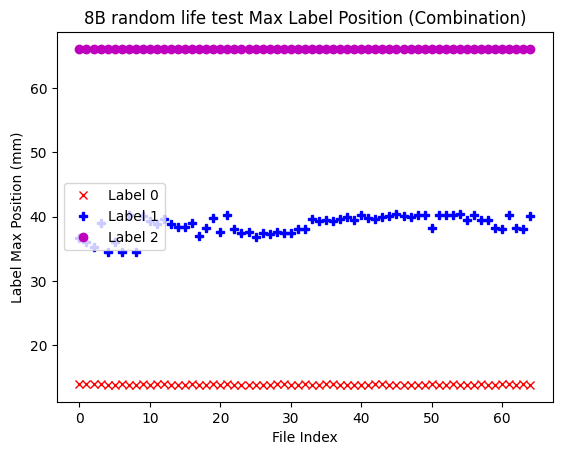

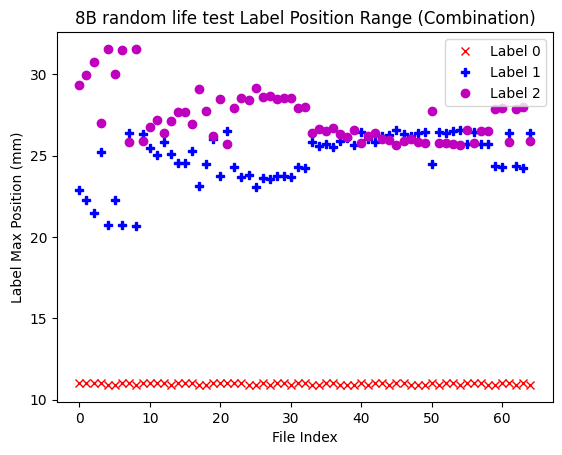

In [80]:
pos0 = []
pos1 = []
pos2 = []

pos0_range = []
pos1_range = []
pos2_range = [] 

for path in glob("8B random life test/*.xls"):
    data = dp.loadSetitecXls(path,version="auto_data")  
    pos = np.abs(data['Position (mm)'].values)
    tq = data['I Torque (A)'].values
    # using the raw signals as features
    # not using thrust empty as not all files have it
    X = np.column_stack((data['I Torque (A)'].values,
                        data['I Torque Empty (A)'].values,
                        np.abs(data['Position (mm)'].values),
                        data['I Thrust (A)'].values))
    # inititalize GMM for 2 components (materials)
    YA = GaussianMixture(n_components=2, random_state=0, max_iter=1000,covariance_type='tied',reg_covar=1e-6).fit_predict(X)
    # label 0 of tied is the 2nd half of the signal
    # label 1 is the early portion of air
    YB = GaussianMixture(n_components=2, random_state=0, max_iter=1000,covariance_type='full',reg_covar=1e-6).fit_predict(X)

    ## post process to ensure labels are positively increasing 0 -> 1
    if YA[0] ==1:
        YA=(~YA.astype("bool")).astype(np.int64)
    if YB[0] == 1:
        YB=(~YB.astype("bool")).astype(np.int64)
    
    # process the labels to be 0,1,2
    labels = np.zeros(X.shape[0],dtype=np.int64)
    labels[YB==0] = 0
    labels[YA==1] = 2
    labels[(YB!=0)&(YA!=1)] = 1
    ## check for overlap across labels
    # apply a filling operation
    labels_fix = np.copy(labels)
    for uq in np.unique(labels_fix):
        ii = np.where(labels_fix==uq)[0]
        labels[ii.min():ii.max()] = uq
    # search for peaks
    # append to list
    pos0.append(pos[labels==0].max())
    pos1.append(pos[labels==1].max())
    pos2.append(pos[labels==2].max())

    pos0_range.append(pos[labels==0].max()-pos[labels==0].min())
    pos1_range.append(pos[labels==1].max()-pos[labels==1].min())
    pos2_range.append(pos[labels==2].max()-pos[labels==2].min())
# plot each of the labels
f,ax = plt.subplots()
ax.plot(pos0,'rx',label="Label 0")
ax.plot(pos1,'bP',label="Label 1")
ax.plot(pos2,'mo',label="Label 2")
ax.legend()
ax.set(xlabel="File Index",ylabel="Label Max Position (mm)",title=f"{os.path.dirname(path)} Max Label Position (Combination)")

f,ax = plt.subplots()
ax.plot(pos0_range,'rx',label="Label 0")
ax.plot(pos1_range,'bP',label="Label 1")
ax.plot(pos2_range,'mo',label="Label 2")
ax.legend()
ax.set(xlabel="File Index",ylabel="Label Max Position (mm)",title=f"{os.path.dirname(path)} Label Position Range (Combination)")